## import libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import metrics


from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from xgboost import XGBClassifier

## load and view dataset

In [2]:
# Loading the dataset
df = pd.read_csv("BankChurners.csv")

In [3]:
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

In [4]:
# Dropping columns - ID
df.drop(columns=["CLIENTNUM"], inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

- no missing values
- There are total 21 columns and 10,127 observations in the dataset

Let's check the number of unique values in each column

In [6]:
df.nunique()

Attrition_Flag                 2
Customer_Age                  45
Gender                         2
Dependent_count                6
Education_Level                7
Marital_Status                 4
Income_Category                6
Card_Category                  4
Months_on_book                44
Total_Relationship_Count       6
Months_Inactive_12_mon         7
Contacts_Count_12_mon          7
Credit_Limit                6205
Total_Revolving_Bal         1974
Avg_Open_To_Buy             6813
Total_Amt_Chng_Q4_Q1        1158
Total_Trans_Amt             5033
Total_Trans_Ct               126
Total_Ct_Chng_Q4_Q1          830
Avg_Utilization_Ratio        964
dtype: int64

- Age has only 45 unique values i.e. most of the customers are of similar age
- Categorical variables: Attrition_Flag, Gender, Dependent_count, Education_Level, Marital_Status, Income_Category, Card_Category,Total_Relationship_Count, Months_Inactive_12_mon, Contacts_Count_12_mon 


In [7]:
# Making a list of all catrgorical variables
cat_col = [
    "Attrition_Flag",
    "Gender",
    "Dependent_count",
    "Education_Level",
    "Marital_Status",
    "Income_Category",
    "Card_Category",
    "Total_Relationship_Count",
    "Months_Inactive_12_mon",
    "Contacts_Count_12_mon"
]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(df[column].value_counts())
    print("-" * 40)

Existing Customer    8500
Attrited Customer    1627
Name: Attrition_Flag, dtype: int64
----------------------------------------
F    5358
M    4769
Name: Gender, dtype: int64
----------------------------------------
3    2732
2    2655
1    1838
4    1574
0     904
5     424
Name: Dependent_count, dtype: int64
----------------------------------------
Graduate         3128
High School      2013
Unknown          1519
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64
----------------------------------------
Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital_Status, dtype: int64
----------------------------------------
Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64
----------------------------------------
Blue        9436
Silver       555
Gold         116
Platin

In [8]:
# for education - to combine graduate with college
# We can see that the distribution of classes in the target variable is imbalanced i.e. only 15% observations with attrition.

In [9]:
# Replacing college with graduate
df["Education_Level"] = df["Education_Level"].replace("College", "Graduate")

In [10]:
(df["Education_Level"].value_counts())

Graduate         4141
High School      2013
Unknown          1519
Uneducated       1487
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

In [11]:
df.describe().T

count         mean          std     min       25%  \
Customer_Age              10127.0    46.325960     8.016814    26.0    41.000   
Dependent_count           10127.0     2.346203     1.298908     0.0     1.000   
Months_on_book            10127.0    35.928409     7.986416    13.0    31.000   
Total_Relationship_Count  10127.0     3.812580     1.554408     1.0     3.000   
Months_Inactive_12_mon    10127.0     2.341167     1.010622     0.0     2.000   
Contacts_Count_12_mon     10127.0     2.455317     1.106225     0.0     2.000   
Credit_Limit              10127.0  8631.953698  9088.776650  1438.3  2555.000   
Total_Revolving_Bal       10127.0  1162.814061   814.987335     0.0   359.000   
Avg_Open_To_Buy           10127.0  7469.139637  9090.685324     3.0  1324.500   
Total_Amt_Chng_Q4_Q1      10127.0     0.759941     0.219207     0.0     0.631   
Total_Trans_Amt           10127.0  4404.086304  3397.129254   510.0  2155.500   
Total_Trans_Ct            10127.0    64.858695    23.472570    10.0    45.000   
Total_Ct_Chng_Q4_Q1       10127.0     0.712222     0.238086     0.0     0.582   
Avg_Utilization_Ratio     10127.0     0.274894     0.275691     0.0     0.023   

                               50%        75%        max  
Customer_Age                46.000     52.000     73.000  
Dependent_count              2.000      3.000      5.000  
Months_on_book              36.000     40.000     56.000  
Total_Relationship_Count     4.000      5.000      6.000  
Months_Inactive_12_mon       2.000      3.000      6.000  
Contacts_Count_12_mon        2.000      3.000      6.000  
Credit_Limit              4549.000  11067.500  34516.000  
Total_Revolving_Bal       1276.000   1784.000   2517.000  
Avg_Open_To_Buy           3474.000   9859.000  34516.000  
Total_Amt_Chng_Q4_Q1         0.736      0.859      3.397  
Total_Trans_Amt           3899.000   4741.000  18484.000  
Total_Trans_Ct              67.000     81.000    139.000  
Total_Ct_Chng_Q4_Q1          0.702      0.818      3.714  
Avg_Utilization_Ratio        0.176      0.503      0.999

- Mean value for the age column is approx 46 and median is 46. Age follows a normal distribution
- Most other variables seems to follow a normal distribution as well, with mean and median being quite similar.
- Maximum months on book is 56, which is about 4years8months. Hence there is less than 5 years of records.
- Avg_Open_To_Buy is right skewed
- Avg_Utilization_Ratio is right skewed, most people tend to use less than 17% of their credit. 

Univariate analysis

In [12]:
# writing a function for univariate analysis
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, color="orange"
    ) if bins else sns.distplot(
        feature, kde=False, ax=ax_hist2, color="tab:cyan"
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="purple", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram

In [13]:
cont_var = df.describe().T.index.tolist()
cont_var

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

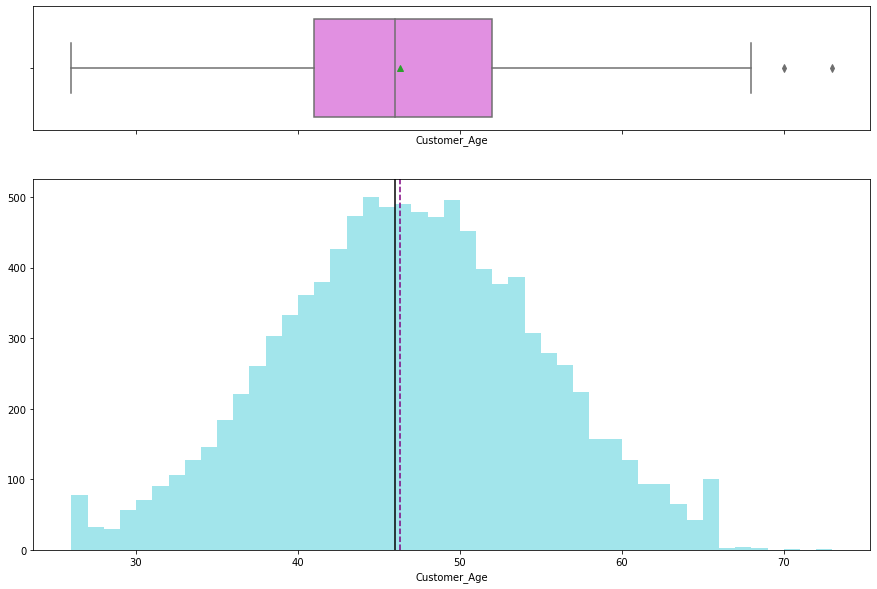

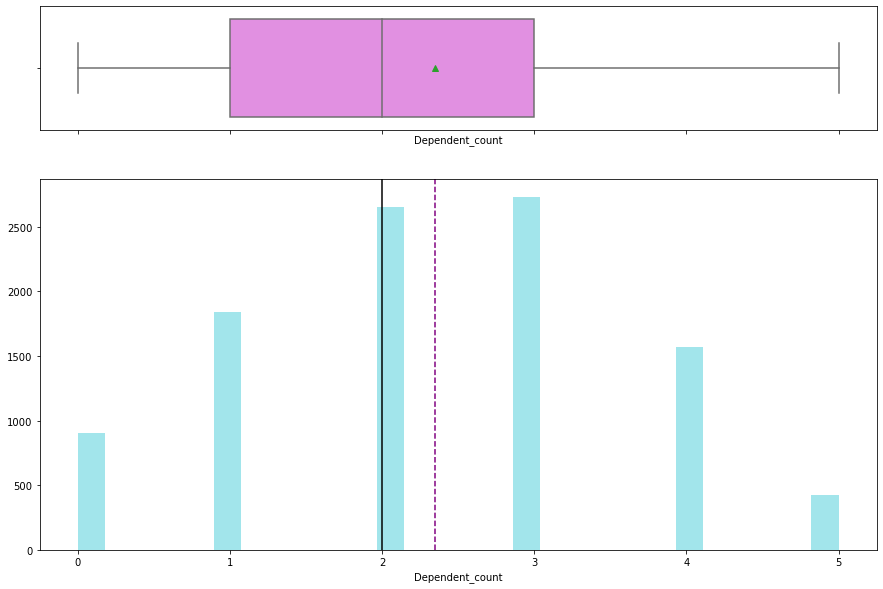

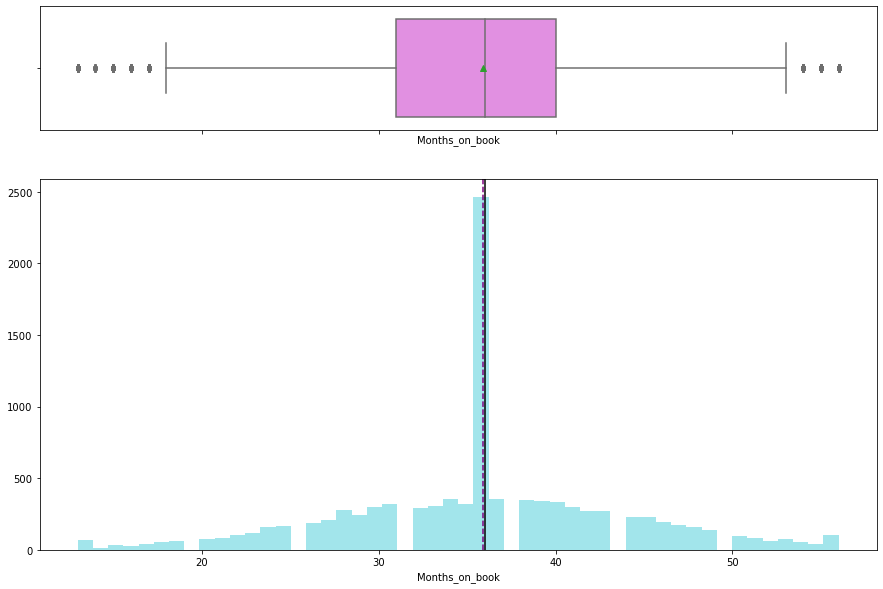

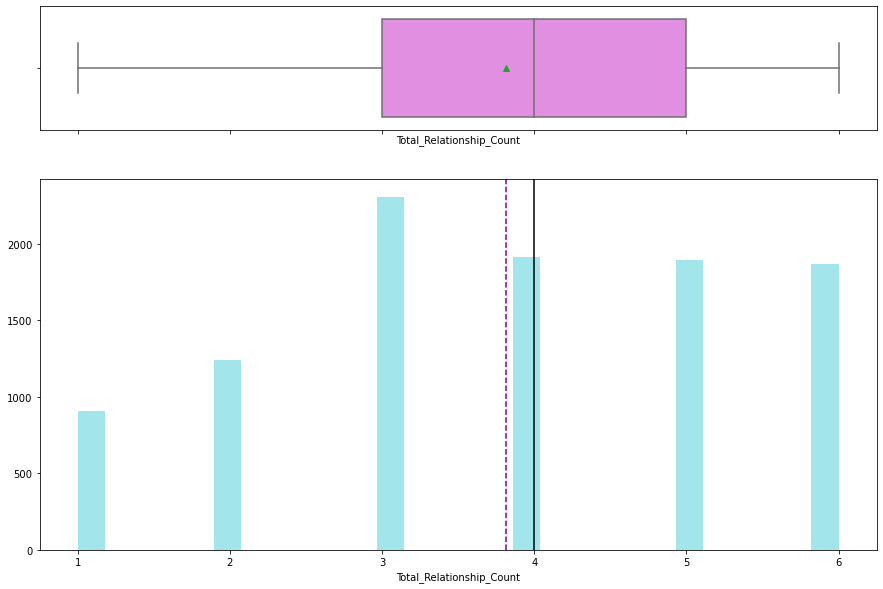

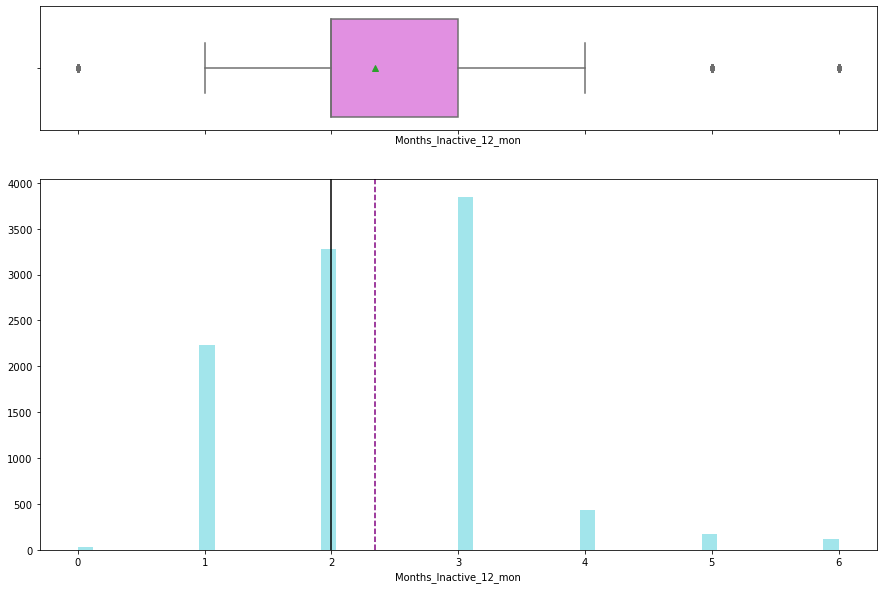

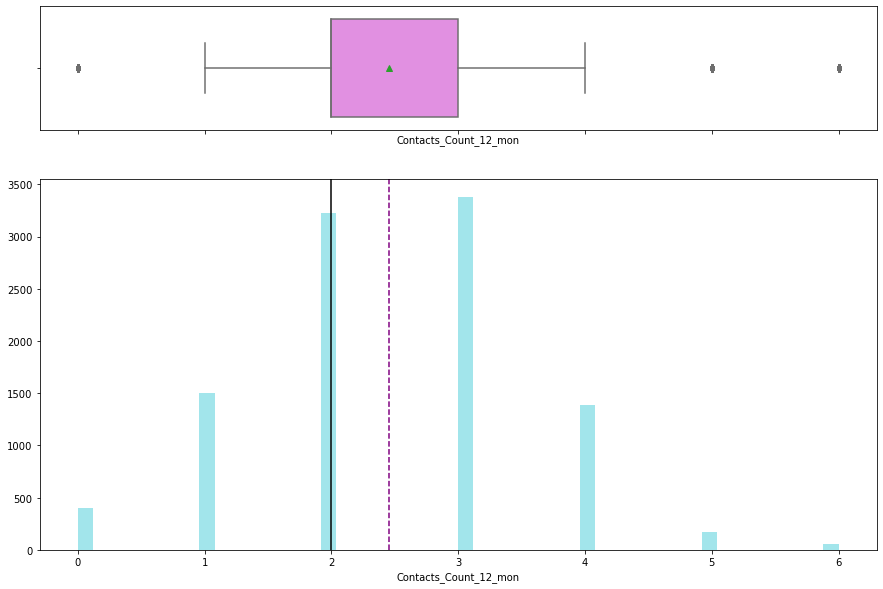

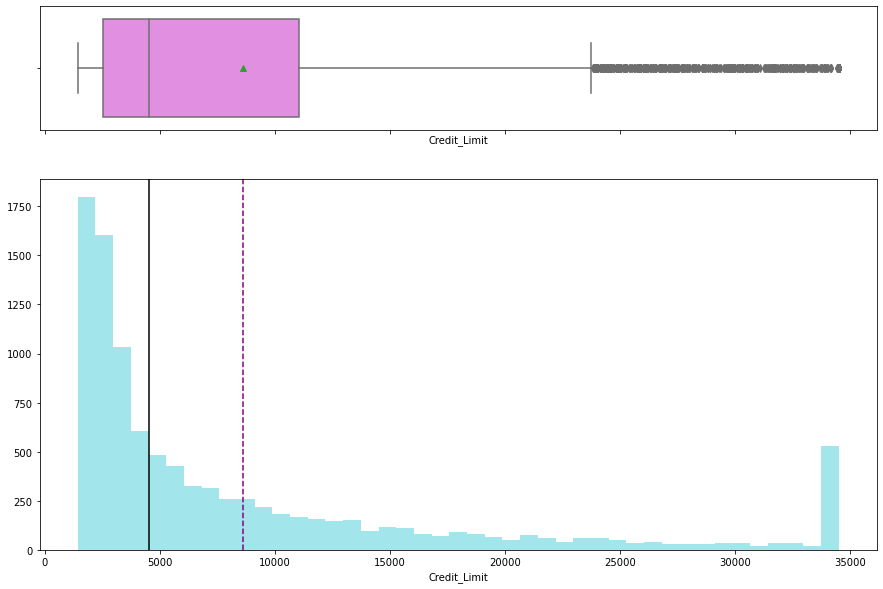

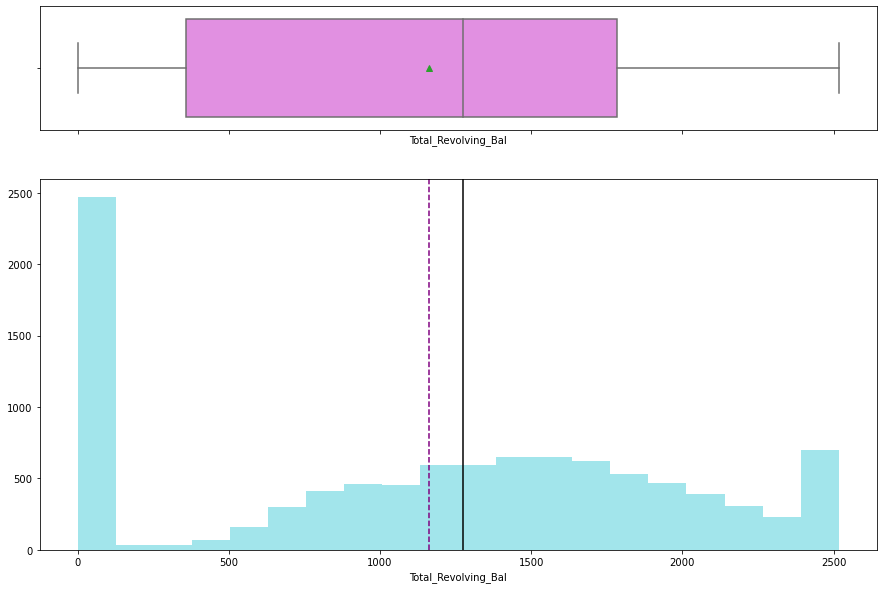

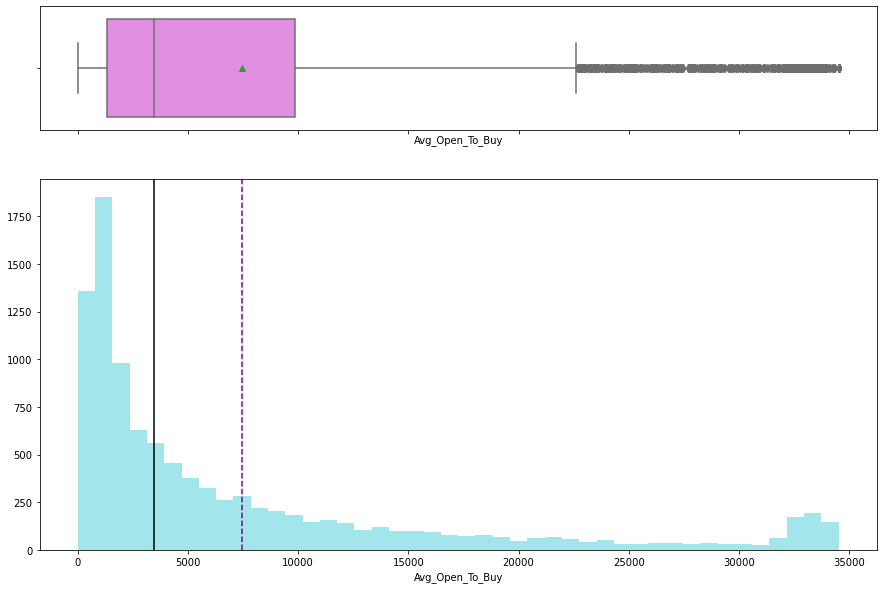

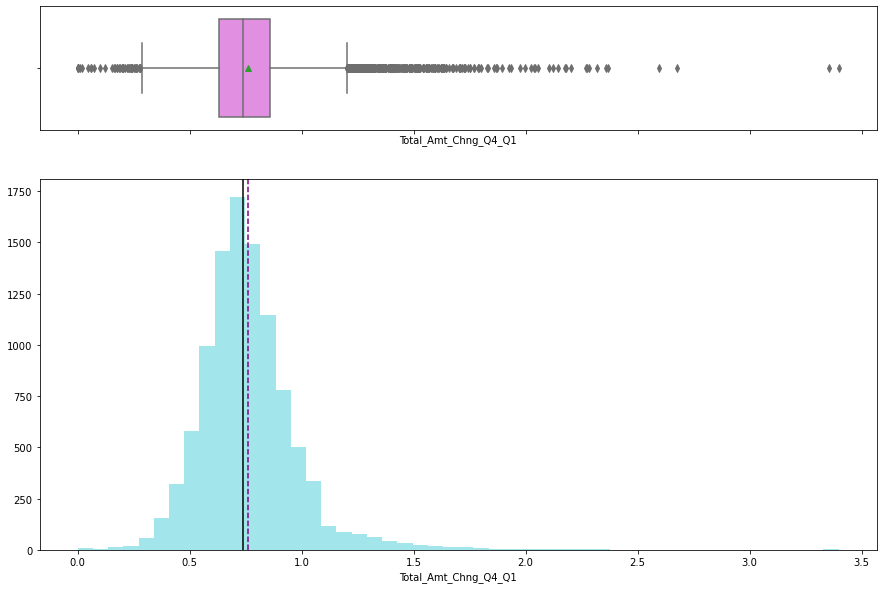

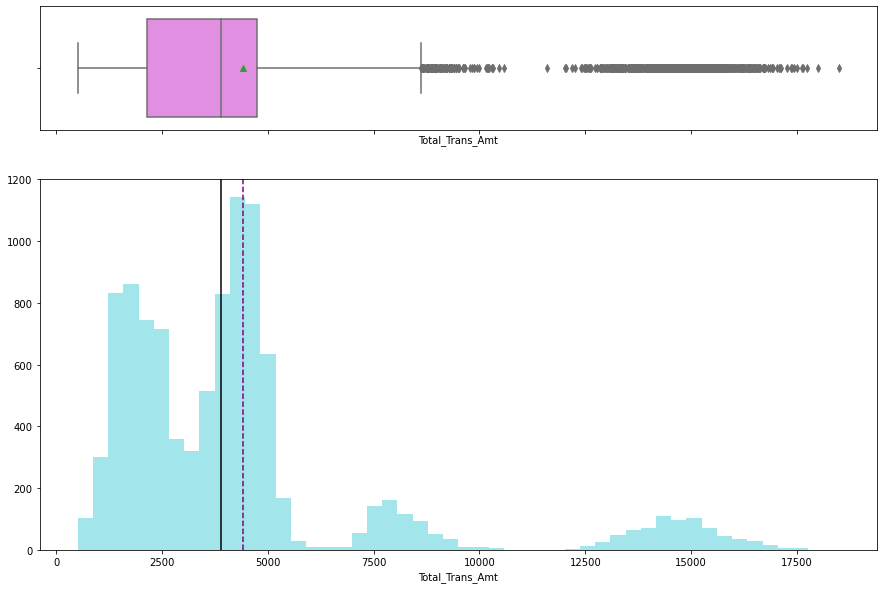

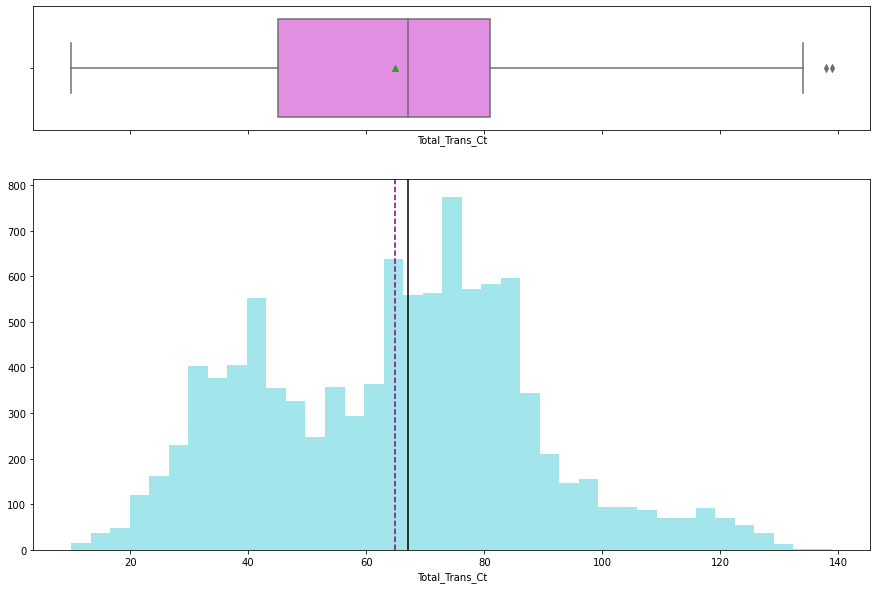

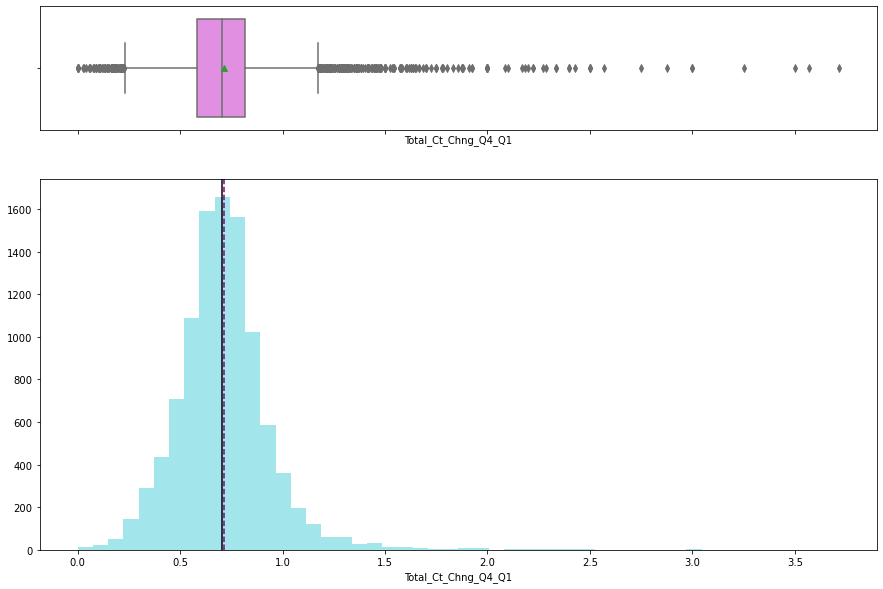

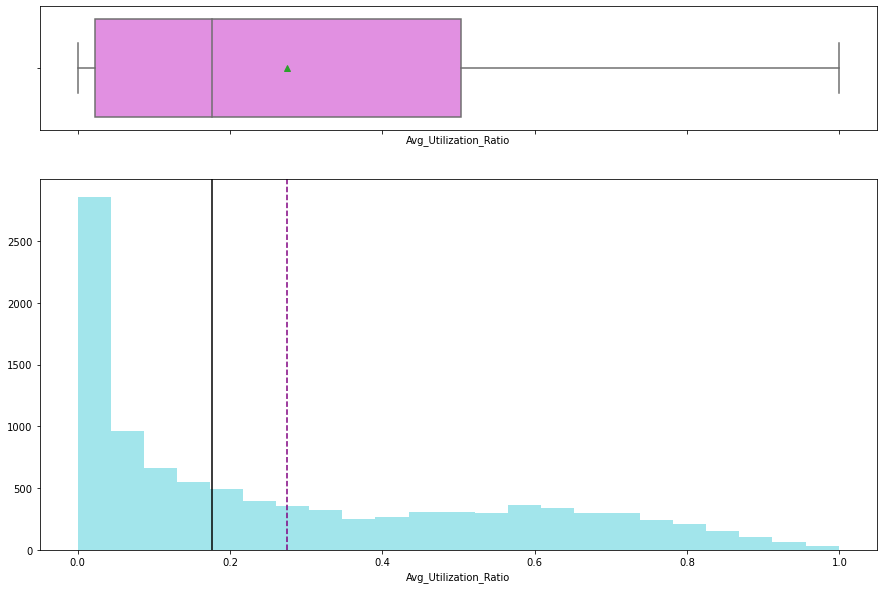

In [14]:
for col in cont_var:
    histogram_boxplot(df[col])

# interesting observations
- months_on_book: there is an unusually high no of customers with month of book of ~36months
- credit limit shows a right skew, with most customers having only a small amount. However, there is also a spike near the 35k, which probably shows that the bank offers a max of <35k credit limit, no matter how good the client profile.
- many are not holding any total revolving balance - can consider creating a variable as Yes/No revolving balance
- total amount change Q4 Q1 has many outliers, which is common in real life. But, there are two outliers in particular that are very far out and may represent incorrect data entries. Will cap these values at the next highest datapoint.


In [15]:
# Checking 5 largest values of Total_Amt_Chng_Q4_Q1
df.Total_Amt_Chng_Q4_Q1.nlargest(10)

12     3.397
8      3.355
773    2.675
2      2.594
219    2.368
47     2.357
46     2.316
658    2.282
58     2.275
466    2.271
Name: Total_Amt_Chng_Q4_Q1, dtype: float64

In [16]:
# Capping values for Total_Amt_Chng_Q4_Q1 at next highest value i.e. 2.675
df["Total_Amt_Chng_Q4_Q1"].clip(upper=2.675, inplace=True)

In [17]:
# adding new variable - is revolving balance zero?
df["zero_revolving_bal"]=np.where(df['Total_Revolving_Bal']==0 , "Zero", ">Zero")
df.head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Unknown  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  ...  Contacts_Count_12_mon  Credit_Limit  \
0                         5  ...                      3       12691.0   
1                         6  ...                      2        8256.0   
2                         4  ...                      0        3418.0   
3                         3  ...                      1        3313.0   
4                         5  ...                      0        4716.0   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                  777          11914.0                 1.335   
1                  864           7392.0                 1.541   
2                    0           3418.0                 2.594   
3                 2517            796.0                 1.405   
4                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0             1144              42                1.625   
1             1291              33                3.714   
2             1887              20                2.333   
3             1171              20                2.333   
4              816              28                2.500   

   Avg_Utilization_Ratio  zero_revolving_bal  
0                  0.061               >Zero  
1                  0.105               >Zero  
2                  0.000                Zero  
3                  0.760               >Zero  
4                  0.000                Zero  

[5 rows x 21 columns]

In [18]:
# Function to create barplots that indicate percentage for each category.


def perc_on_bar(plot, feature):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    """
    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=12)  # annotate the percantage
    plt.show()  # show the plot

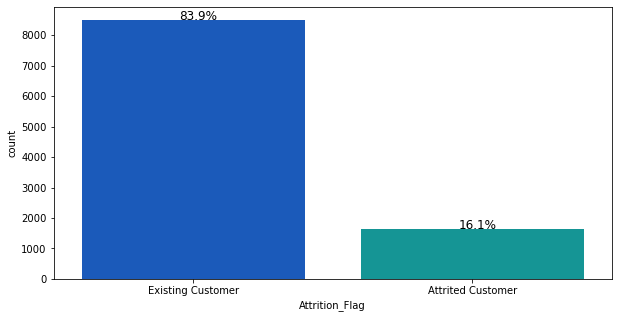

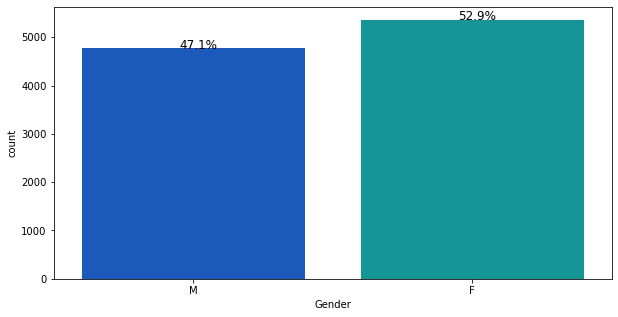

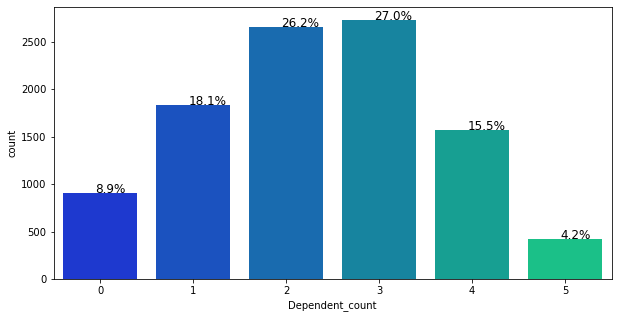

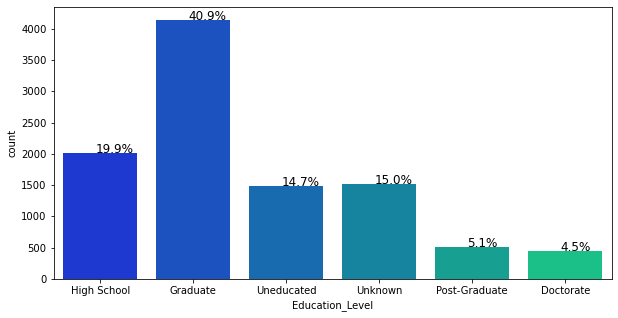

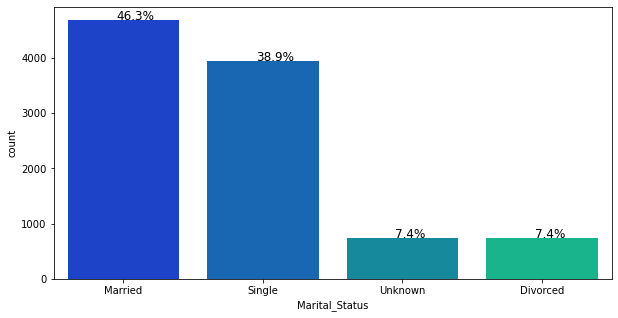

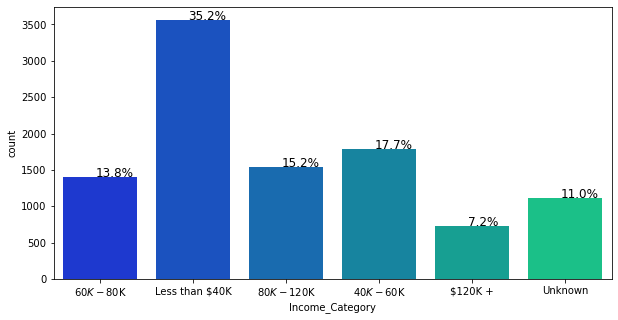

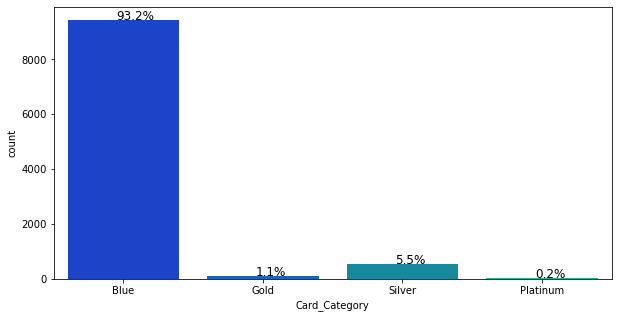

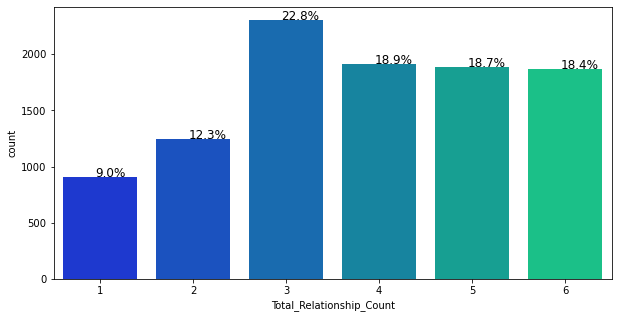

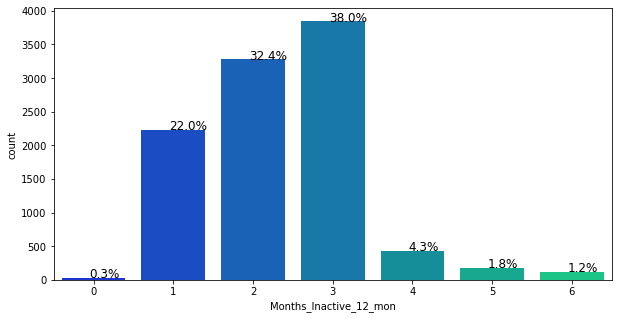

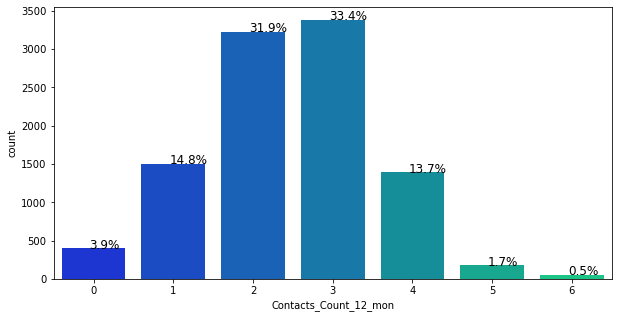

In [19]:
for col in cat_col:
    plt.figure(figsize=(10, 5))
    ax = sns.countplot(df[col], palette="winter")
    perc_on_bar(ax, df[col])

In [20]:
# there is uneven distribution for the y variable - attrition
# about half of the customers are of graduate level education(40%)
# the largest group of the customers earn less than 40k
# almost all the customers applied for the blue credit card

## Bivariante analysis

<Figure size 1440x720 with 0 Axes>

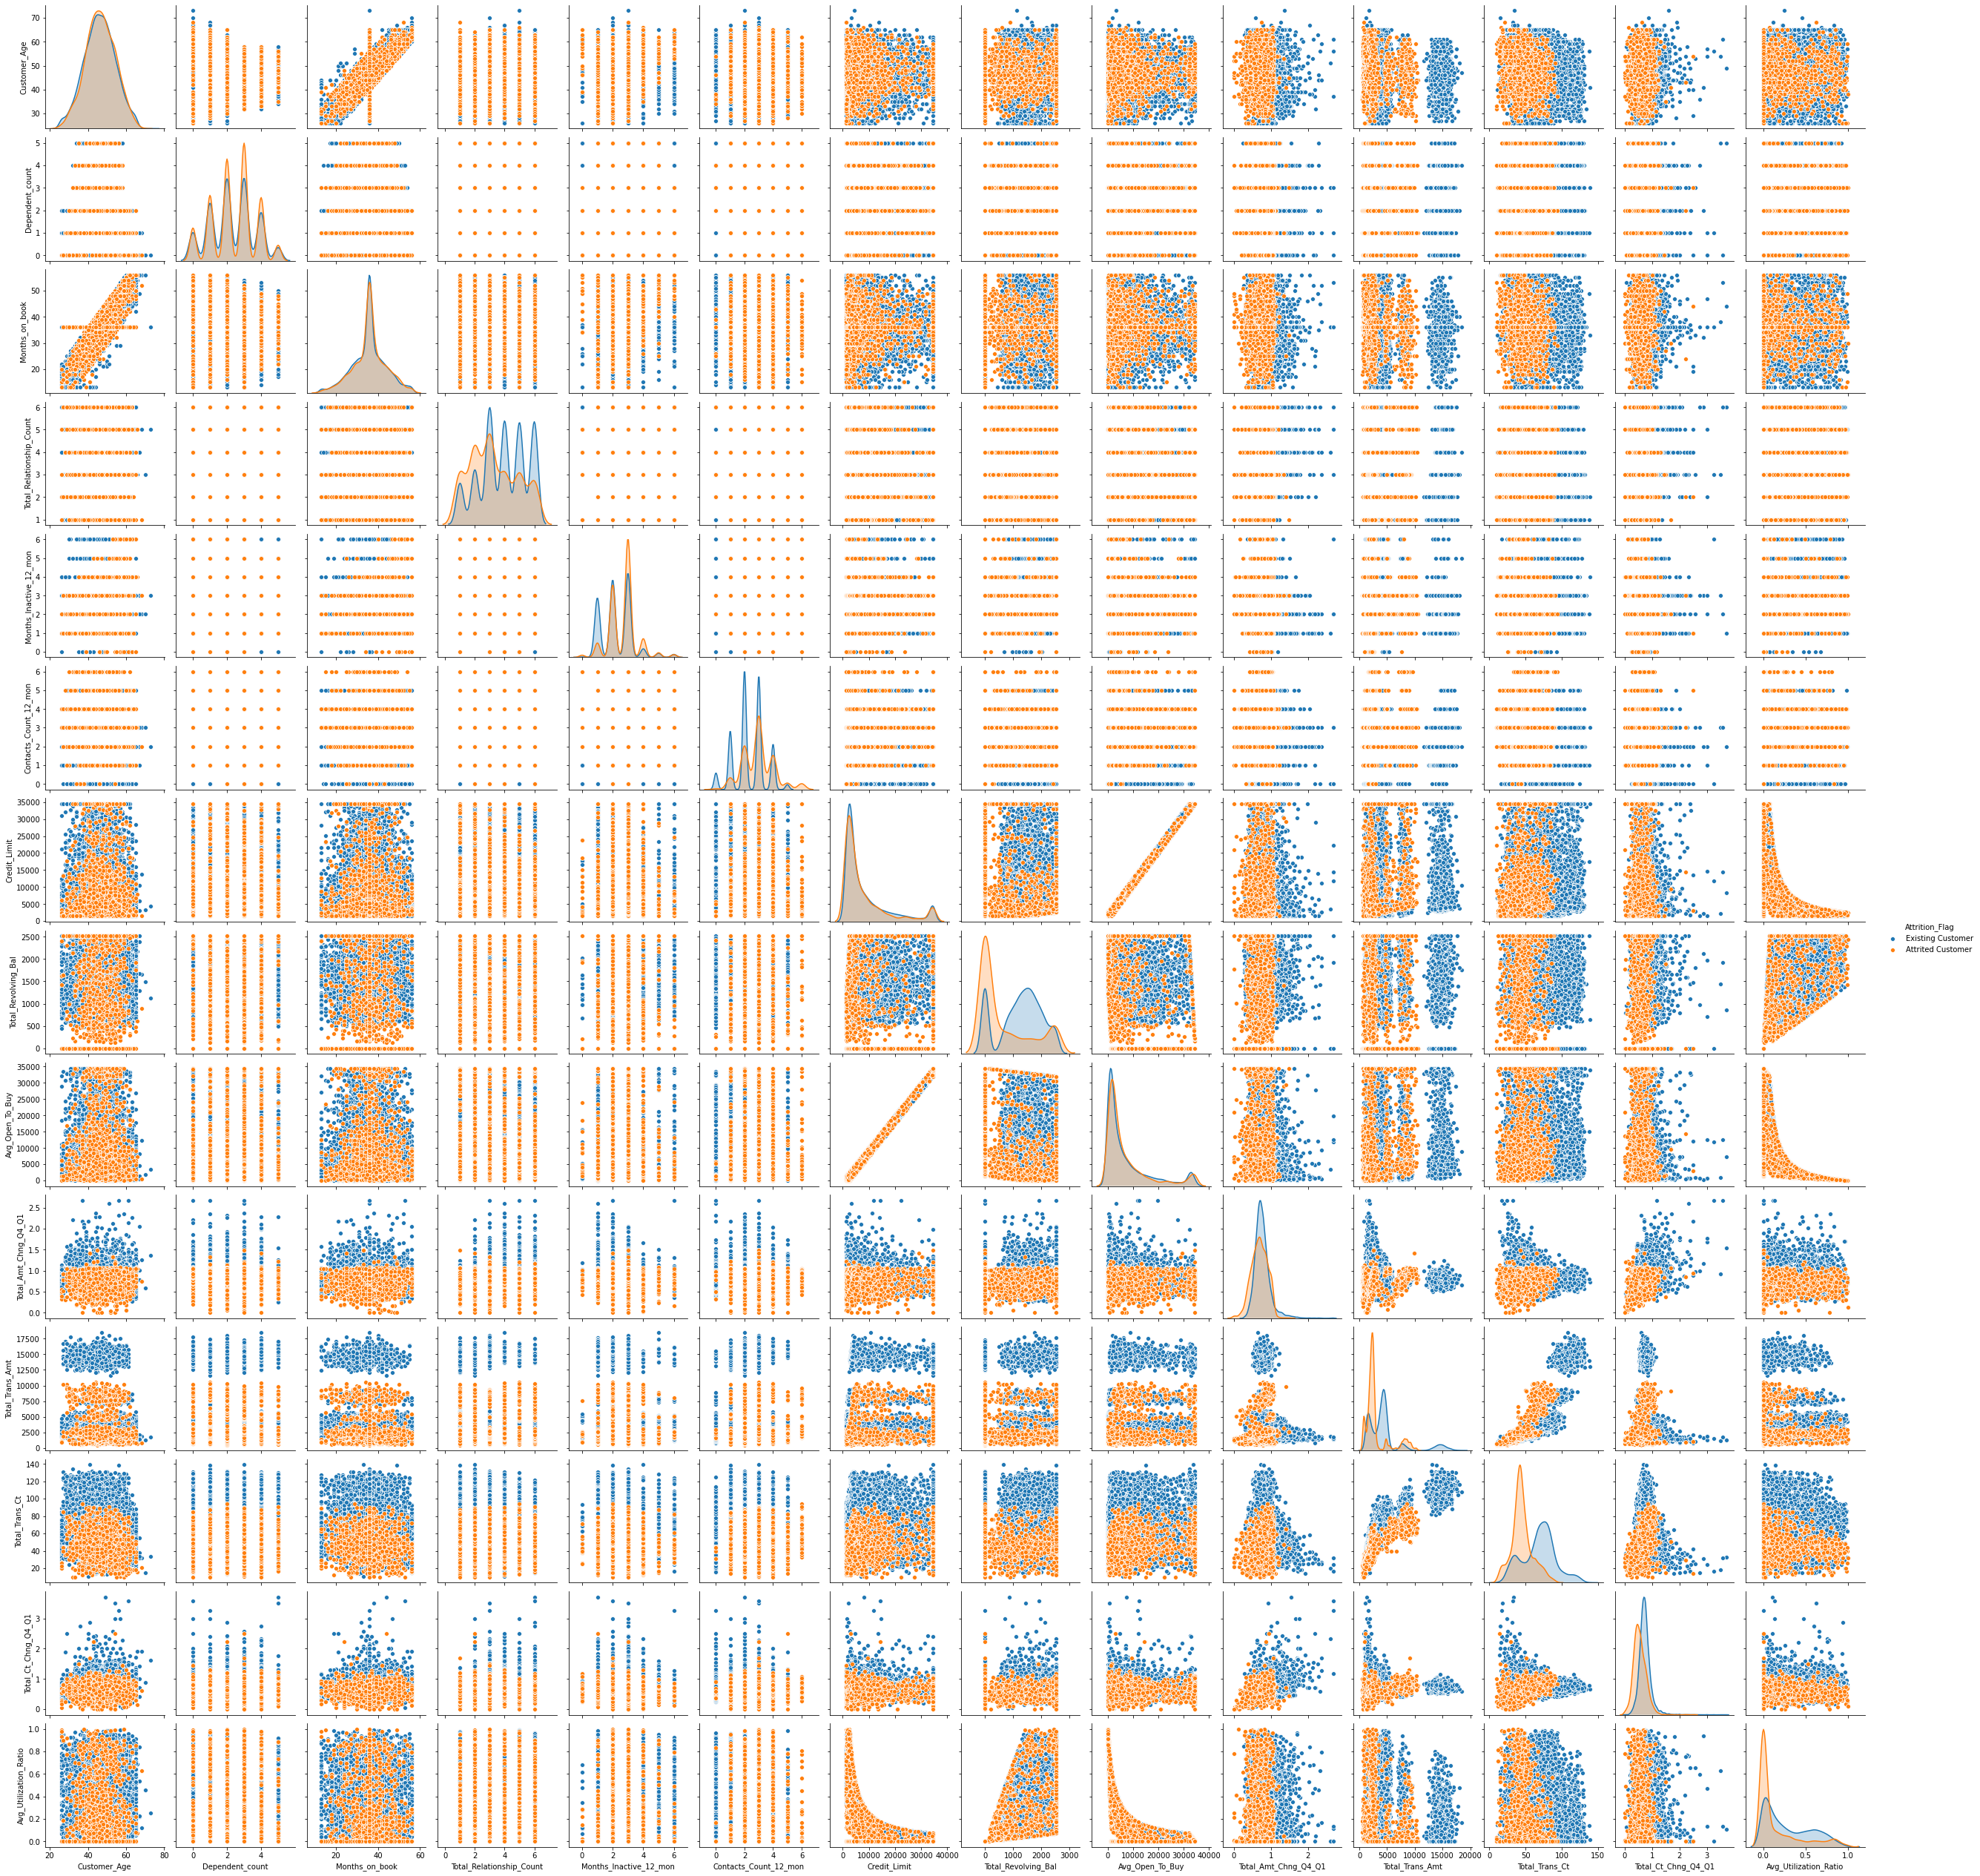

In [21]:
plt.figure(figsize=(20, 10))
sns.pairplot(df, hue="Attrition_Flag")

In [22]:
# for some of the variables, there is a clear distinction between attrited clients and existing clients. Lets explore this further

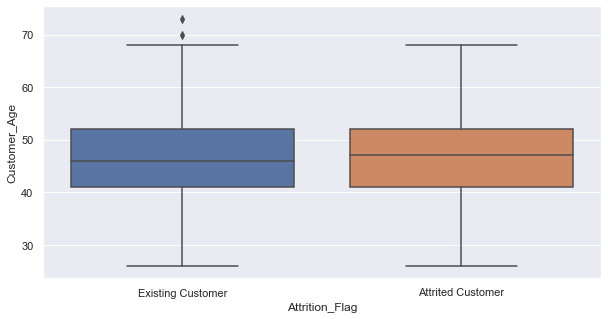

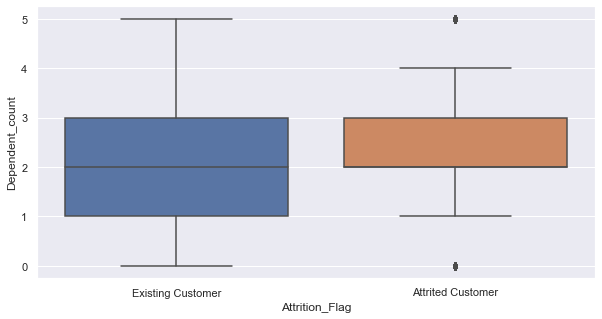

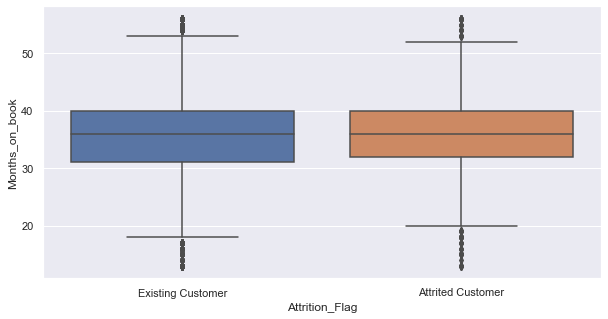

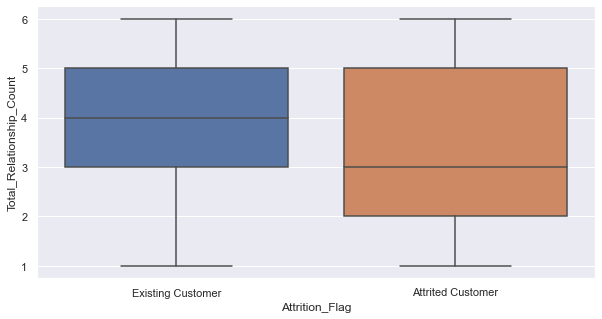

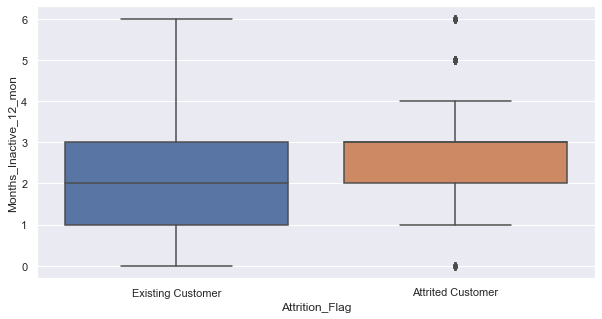

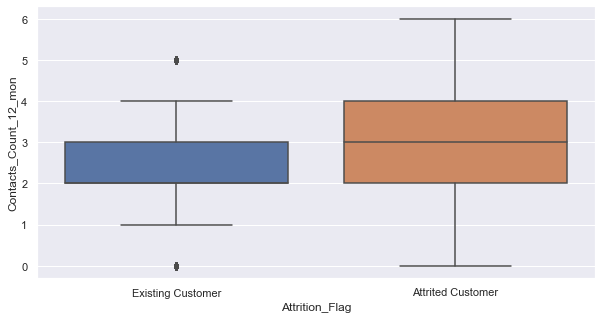

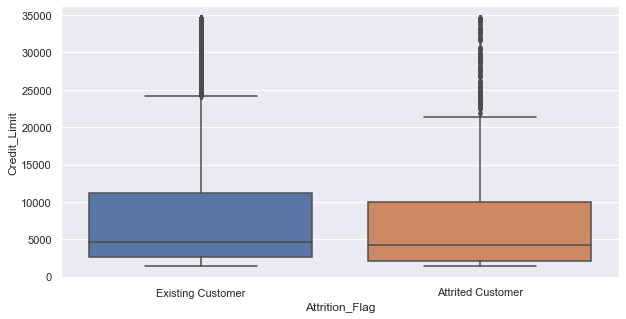

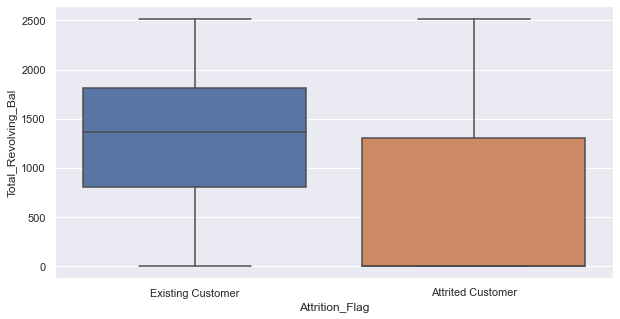

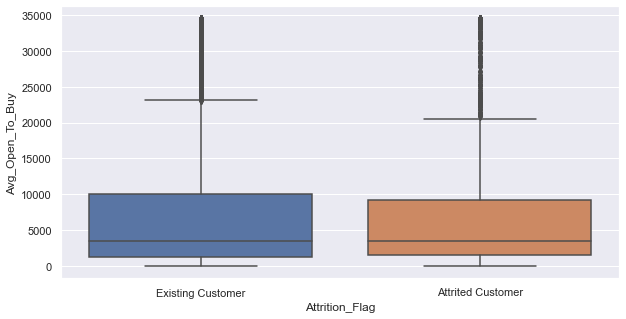

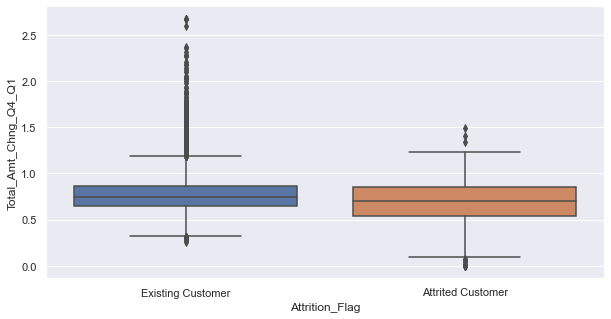

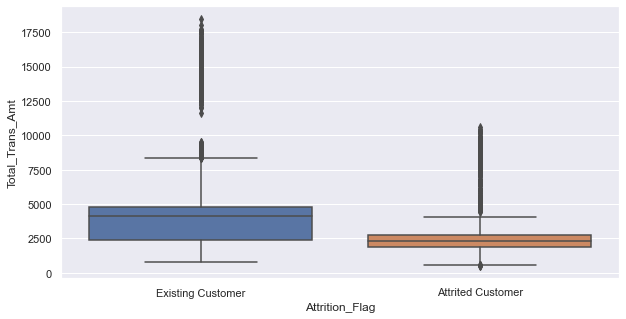

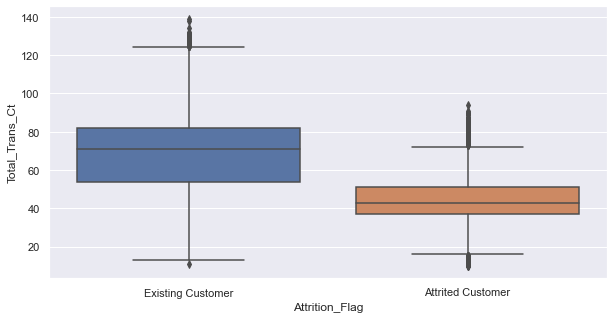

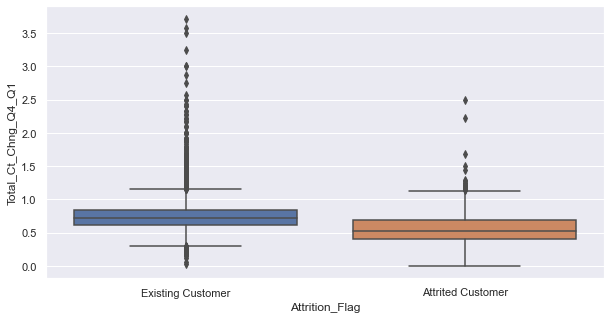

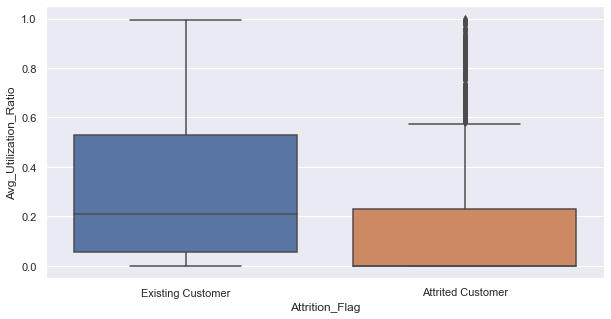

In [23]:
for col in cont_var:
    plt.figure(figsize=(10, 5))
    sns.set(rc={"figure.figsize": (10, 7)})
    sns.boxplot(x="Attrition_Flag", y=col, data=df, orient="vertical")

In [24]:
# attrited clients have lower avg utilization rations, smaller count change from Q4 to Q1, transaction counts and amounts, and zero to low revolving bal
# these are likely lower as client has already gone inactive and stopped using the credit card
# attrited clients are more likely to have been contacted more times in the past 12 months



In [25]:
## Function to plot stacked bar chart
def stacked_plot(x):
    sns.set(palette="nipy_spectral")
    tab1 = pd.crosstab(x, df["Attrition_Flag"], margins=True)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(x, df["Attrition_Flag"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(10, 5))
    # plt.legend(loc='lower left', frameon=False)
    # plt.legend(loc="upper left", bbox_to_anchor=(0,1))
    plt.show()

Attrition_Flag     Attrited Customer  Existing Customer    All
Attrition_Flag                                                
Attrited Customer               1627                  0   1627
Existing Customer                  0               8500   8500
All                             1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


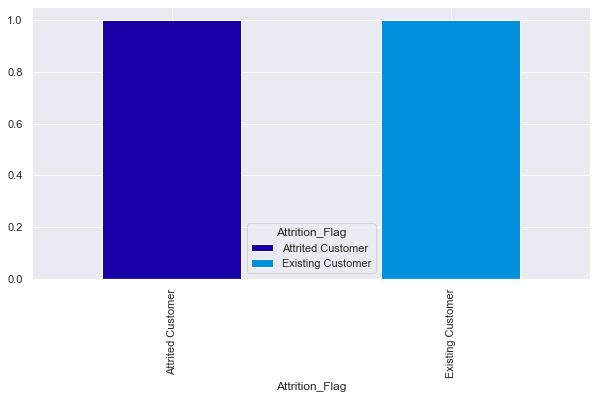

Attrition_Flag  Attrited Customer  Existing Customer    All
Gender                                                     
F                             930               4428   5358
M                             697               4072   4769
All                          1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


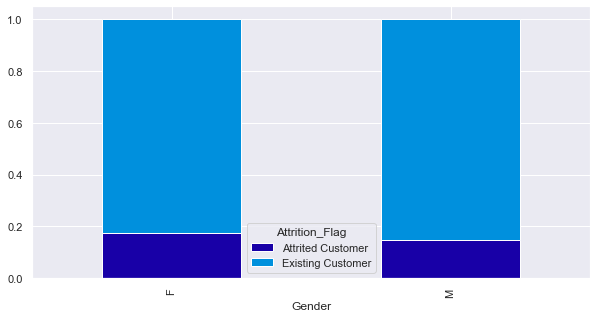

Attrition_Flag   Attrited Customer  Existing Customer    All
Dependent_count                                             
0                              135                769    904
1                              269               1569   1838
2                              417               2238   2655
3                              482               2250   2732
4                              260               1314   1574
5                               64                360    424
All                           1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


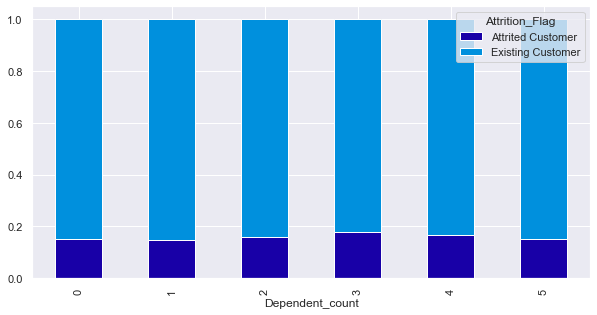

Attrition_Flag   Attrited Customer  Existing Customer    All
Education_Level                                             
Doctorate                       95                356    451
Graduate                       641               3500   4141
High School                    306               1707   2013
Post-Graduate                   92                424    516
Uneducated                     237               1250   1487
Unknown                        256               1263   1519
All                           1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


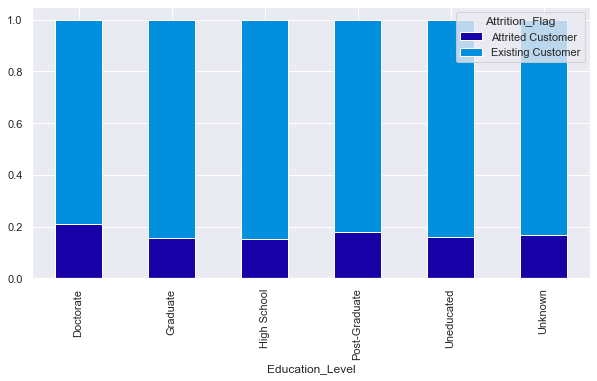

Attrition_Flag  Attrited Customer  Existing Customer    All
Marital_Status                                             
Divorced                      121                627    748
Married                       709               3978   4687
Single                        668               3275   3943
Unknown                       129                620    749
All                          1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


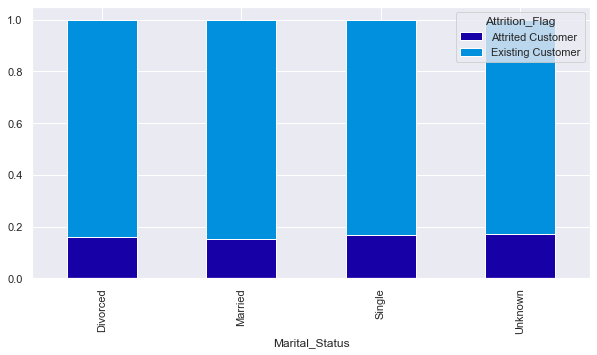

Attrition_Flag   Attrited Customer  Existing Customer    All
Income_Category                                             
$120K +                        126                601    727
$40K - $60K                    271               1519   1790
$60K - $80K                    189               1213   1402
$80K - $120K                   242               1293   1535
Less than $40K                 612               2949   3561
Unknown                        187                925   1112
All                           1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


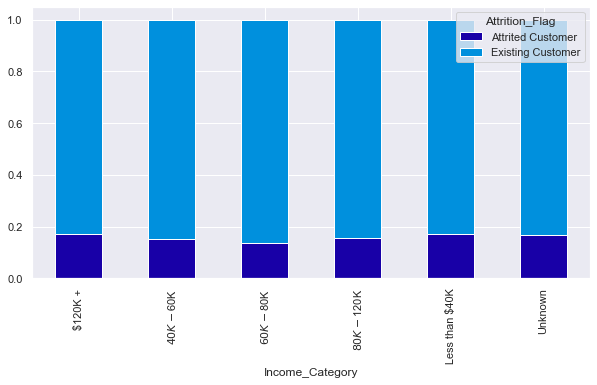

Attrition_Flag  Attrited Customer  Existing Customer    All
Card_Category                                              
Blue                         1519               7917   9436
Gold                           21                 95    116
Platinum                        5                 15     20
Silver                         82                473    555
All                          1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


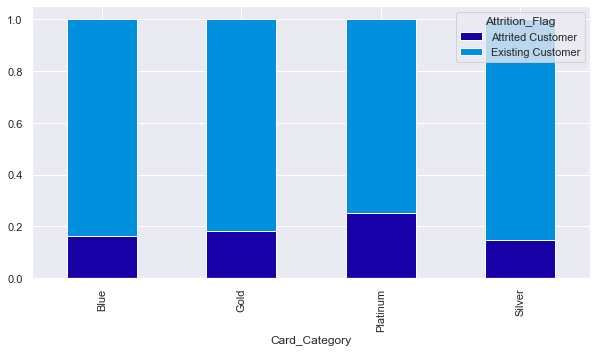

Attrition_Flag            Attrited Customer  Existing Customer    All
Total_Relationship_Count                                             
1                                       233                677    910
2                                       346                897   1243
3                                       400               1905   2305
4                                       225               1687   1912
5                                       227               1664   1891
6                                       196               1670   1866
All                                    1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


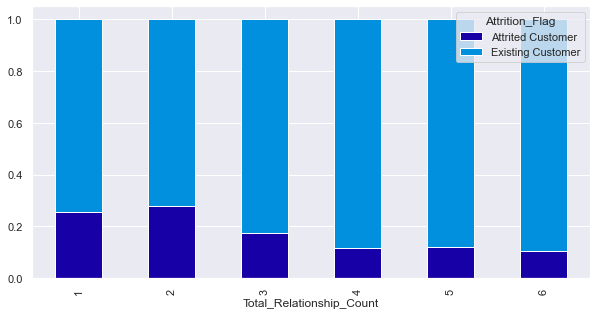

Attrition_Flag          Attrited Customer  Existing Customer    All
Months_Inactive_12_mon                                             
0                                      15                 14     29
1                                     100               2133   2233
2                                     505               2777   3282
3                                     826               3020   3846
4                                     130                305    435
5                                      32                146    178
6                                      19                105    124
All                                  1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


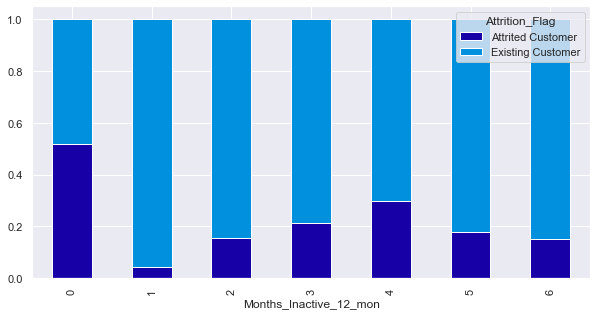

Attrition_Flag         Attrited Customer  Existing Customer    All
Contacts_Count_12_mon                                             
0                                      7                392    399
1                                    108               1391   1499
2                                    403               2824   3227
3                                    681               2699   3380
4                                    315               1077   1392
5                                     59                117    176
6                                     54                  0     54
All                                 1627               8500  10127
------------------------------------------------------------------------------------------------------------------------


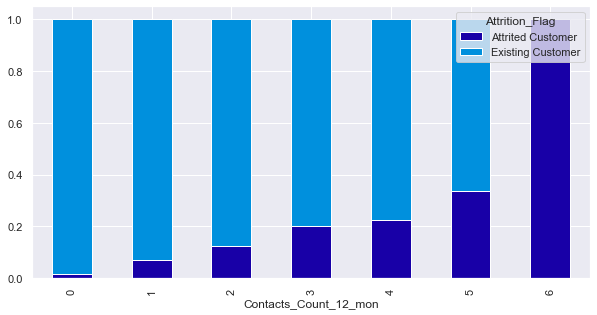

In [26]:
for col in cat_col:
    stacked_plot(df[col])

In [27]:
# attrited customers tend to have 3-4 dependents
# attrited customers tend to have post-graduate or doctorate education - ie. they are highly educated
# a larger percentage of attrited customers tend to earn <40k
# the card type with the largest proportion of attrited is Platinum
# attrited customers tend to have less relationship with the bank (1-2)
# Many customers attrited this month and 4 months ago
# Attrited customers are likely to have been contacted many times

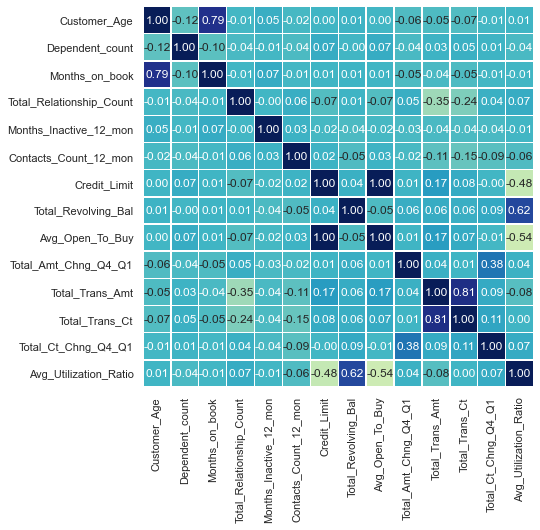

In [28]:
sns.set(rc={"figure.figsize": (7, 7)})
sns.heatmap(
    df.corr(),
    annot=True,
    linewidths=0.5,
    center=0,
    cbar=False,
    cmap="YlGnBu",
    fmt="0.2f",
)
plt.show()

In [29]:
# customer age and months on book highly correlated - because the older they are, the longer the period they have been old enough to apply for a card
# total trans amt and count highly related - the more times of trans, amt is likely to be higher

Model Building - Approach
- Partition the data into train and test set.
- Treat missing values using KNNImputer
- Built different classifiers using K-Fold cross validation, pipelines and StandardScaler.
- Hyperparameter tuning the model which gives the best cross validation score
- Build the model using optimal hyperparameters and test the performance on the test set.

Model evaluation criterion

We will be using Recall as a metric for our model performance, because here company could face 2 types of losses
- spend money winning back customers that were not planning to attrite - Loss of campaigning money
- not identifying and winning back customers who are going to attrite - Loss of revenue

Which Loss is greater ?
- not identifying the customers who are going to attrite

How to reduce this loss i.e need to reduce False Negatives ?
- Company wants recall to be maximized i.e. we need reduce the number of false negatives.

Split data

In [30]:
# Encoding variables - Attrition flag
df["Attrition_Flag"] = df["Attrition_Flag"].map(
    {"Existing Customer": 1, "Attrited Customer": 0}
)
df.head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0               1            45      M                3     High School   
1               1            49      F                5        Graduate   
2               1            51      M                3        Graduate   
3               1            40      F                4     High School   
4               1            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Unknown  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  ...  Contacts_Count_12_mon  Credit_Limit  \
0                         5  ...                      3       12691.0   
1                         6  ...                      2        8256.0   
2                         4  ...                      0        3418.0   
3                         3  ...                      1        3313.0   
4                         5  ...                      0        4716.0   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                  777          11914.0                 1.335   
1                  864           7392.0                 1.541   
2                    0           3418.0                 2.594   
3                 2517            796.0                 1.405   
4                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0             1144              42                1.625   
1             1291              33                3.714   
2             1887              20                2.333   
3             1171              20                2.333   
4              816              28                2.500   

   Avg_Utilization_Ratio  zero_revolving_bal  
0                  0.061               >Zero  
1                  0.105               >Zero  
2                  0.000                Zero  
3                  0.760               >Zero  
4                  0.000                Zero  

[5 rows x 21 columns]

In [31]:
X = df.drop(["Attrition_Flag"], axis=1)
y = df["Attrition_Flag"]

In [32]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)
print(X_train.shape, X_test.shape)

(7088, 20) (3039, 20)


In [33]:
# Creating dummy variables for categorical variables
X_train = pd.get_dummies(data=X_train, drop_first=True)
X_test = pd.get_dummies(data=X_test, drop_first=True)


In [34]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model, flag=True):
    """
    model : classifier to predict values of X

    """
    # defining an empty list to store train and test results
    score_list = []

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    train_recall = metrics.recall_score(y_train, pred_train)
    test_recall = metrics.recall_score(y_test, pred_test)

    train_precision = metrics.precision_score(y_train, pred_train)
    test_precision = metrics.precision_score(y_test, pred_test)

    score_list.extend(
        (
            train_acc,
            test_acc,
            train_recall,
            test_recall,
            train_precision,
            test_precision,
        )
    )

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ", model.score(X_train, y_train))
        print("Accuracy on test set : ", model.score(X_test, y_test))
        print("Recall on training set : ", metrics.recall_score(y_train, pred_train))
        print("Recall on test set : ", metrics.recall_score(y_test, pred_test))
        print(
            "Precision on training set : ", metrics.precision_score(y_train, pred_train)
        )
        print("Precision on test set : ", metrics.precision_score(y_test, pred_test))

    return score_list  # returning the list with train and test scores

In [35]:
## Function to create confusion matrix
def make_confusion_matrix(model, y_actual, labels=[1, 0]):
    """
    model : classifier to predict values of X
    y_actual : ground truth

    """
    y_predict = model.predict(X_test)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    data_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - No", "Actual - Yes"]],
        columns=[i for i in ["Predicted - No", "Predicted - Yes"]],
    )
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(data_cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [36]:
# log regression
lr = LogisticRegression(random_state=1)
lr.fit(X_train,y_train)

LogisticRegression(random_state=1)

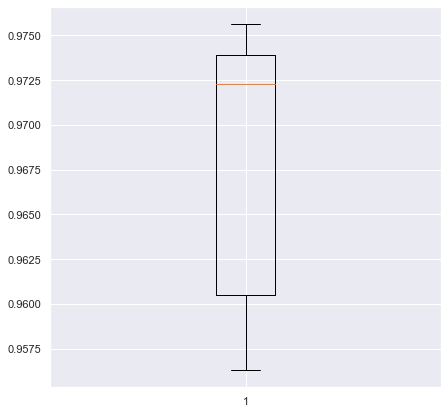

In [37]:
scoring='recall'
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)     #Setting number of splits equal to 5
cv_result_bfr=cross_val_score(estimator=lr, X=X_train, y=y_train, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_bfr)
plt.show()

In [38]:
# performance on training set varies from 0.9575 to .9750


Accuracy on training set :  0.8769751693002258
Accuracy on test set :  0.8772622573214873
Recall on training set :  0.9687342410489158
Recall on test set :  0.9717757742061937
Precision on training set :  0.8936269189021554
Precision on test set :  0.891726618705036


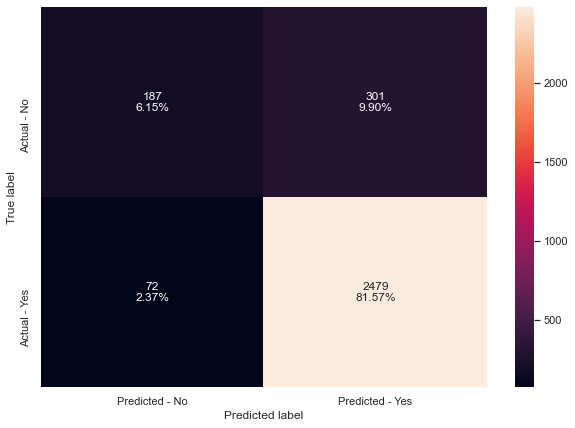

In [39]:
#test recall score
# Calculating different metrics
get_metrics_score(lr)

# Creating confusion matrix
make_confusion_matrix(lr, y_test)

In [40]:
# test and training data showing similar results -> no overfitting

## Oversampling train data using SMOTE

In [41]:
from imblearn.over_sampling import SMOTE

In [42]:
print("Before UpSampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before UpSampling, counts of label 'No': {} \n".format(sum(y_train==0)))

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over==0)))


print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Yes': 5949
Before UpSampling, counts of label 'No': 1139 

After UpSampling, counts of label 'Yes': 5949
After UpSampling, counts of label 'No': 5949 

After UpSampling, the shape of train_X: (11898, 32)
After UpSampling, the shape of train_y: (11898,) 



In [43]:
# Logistic Regression on oversampled data
log_reg_over = LogisticRegression(random_state = 1)

# Training the basic logistic regression model with training set 
log_reg_over.fit(X_train_over,y_train_over)

LogisticRegression(random_state=1)

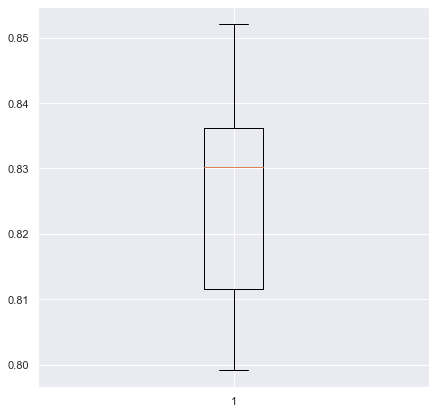

In [44]:
scoring='recall'
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)     #Setting number of splits equal to 5
cv_result_over=cross_val_score(estimator=log_reg_over, X=X_train_over, y=y_train_over, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_over)
plt.show()

In [45]:
# the recall score greatly dropped from the 95% range to 80+% range

Accuracy on training set :  0.8306997742663657
Accuracy on test set :  0.8272458045409674
Recall on training set :  0.8377878635064717
Recall on test set :  0.8377107016856135
Precision on training set :  0.9549722168997893
Precision on test set :  0.9506227758007118


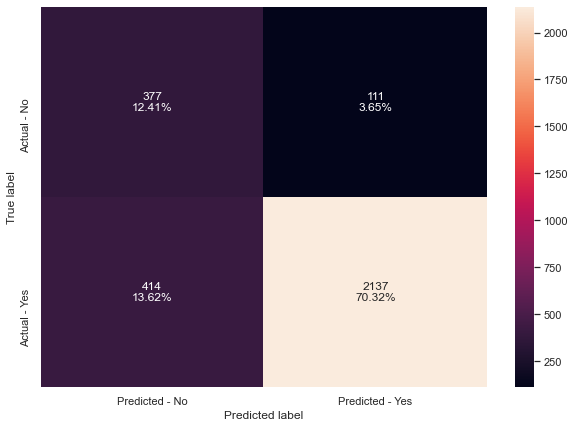

In [46]:
#Calculating different metrics
get_metrics_score(log_reg_over)

# creating confusion matrix
make_confusion_matrix(log_reg_over,y_test)

In [47]:
# Regularization
lr_estimator = LogisticRegression(random_state=1,solver='saga')

# Grid of parameters to choose from
parameters = {'C': np.arange(0.1,1.1,0.1)}

# Run the grid search
grid_obj = GridSearchCV(lr_estimator, parameters, scoring='recall')
grid_obj = grid_obj.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
lr_estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
lr_estimator.fit(X_train_over, y_train_over)

LogisticRegression(C=0.1, random_state=1, solver='saga')

Accuracy on training set :  0.804176072234763
Accuracy on test set :  0.8068443566962816
Recall on training set :  0.8524121701126239
Recall on test set :  0.8573108584868679
Precision on training set :  0.9086185271456728
Precision on test set :  0.9074688796680498


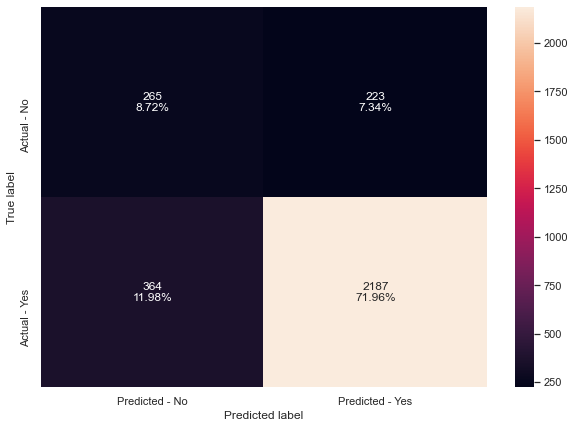

In [48]:
#Calculating different metrics
get_metrics_score(lr_estimator)

# creating confusion matrix
make_confusion_matrix(lr_estimator,y_test)

In [49]:
# recall score is still lower than that of the original data, but little overfitting

In [50]:
# Undersampling train data using SMOTE
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [51]:
print("Before Under Sampling, counts of label 'Yes': {}".format(sum(y_train==1)))
print("Before Under Sampling, counts of label 'No': {} \n".format(sum(y_train==0)))

print("After Under Sampling, counts of label 'Yes': {}".format(sum(y_train_un==1)))
print("After Under Sampling, counts of label 'No': {} \n".format(sum(y_train_un==0)))

print('After Under Sampling, the shape of train_X: {}'.format(X_train_un.shape))
print('After Under Sampling, the shape of train_y: {} \n'.format(y_train_un.shape))

Before Under Sampling, counts of label 'Yes': 5949
Before Under Sampling, counts of label 'No': 1139 

After Under Sampling, counts of label 'Yes': 1139
After Under Sampling, counts of label 'No': 1139 

After Under Sampling, the shape of train_X: (2278, 32)
After Under Sampling, the shape of train_y: (2278,) 



In [52]:
log_reg_under = LogisticRegression(random_state = 1)
log_reg_under.fit(X_train_un,y_train_un )

LogisticRegression(random_state=1)

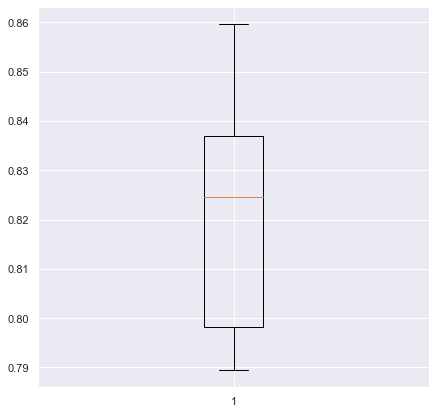

In [53]:
scoring='recall'
kfold=StratifiedKFold(n_splits=5,shuffle=True,random_state=1)     #Setting number of splits equal to 5
cv_result_under=cross_val_score(estimator=log_reg_under, X=X_train_un, y=y_train_un, scoring=scoring, cv=kfold)
#Plotting boxplots for CV scores of model defined above
plt.boxplot(cv_result_under)
plt.show()

Accuracy on training set :  0.8130643340857788
Accuracy on test set :  0.8104639684106614
Recall on training set :  0.807698772903009
Recall on test set :  0.8090944727557821
Precision on training set :  0.9636983553951063
Precision on test set :  0.9586623316302834


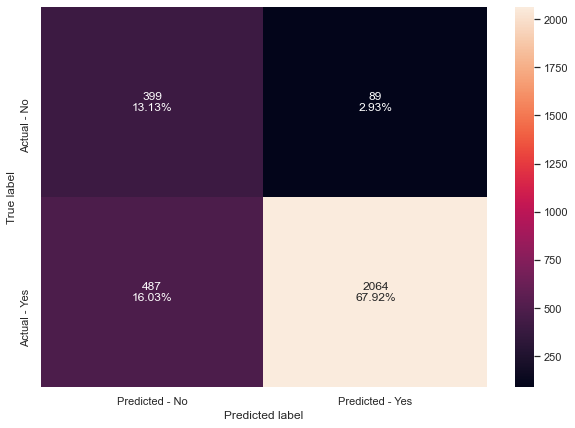

In [54]:
#Calculating different metrics
get_metrics_score(log_reg_under)


# creating confusion matrix
make_confusion_matrix(log_reg_under,y_test)

In [55]:
# undersampling produced an even lower recall score than oversampling

In [57]:
# defining list of model
models = [lr]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:
    
    j = get_metrics_score(model)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

Accuracy on training set :  0.8769751693002258
Accuracy on test set :  0.8772622573214873
Recall on training set :  0.9687342410489158
Recall on test set :  0.9717757742061937
Precision on training set :  0.8936269189021554
Precision on test set :  0.891726618705036


In [58]:
# defining list of models
models = [log_reg_over, lr_estimator]

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:
    
    j = get_metrics_score(model)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

Accuracy on training set :  0.8306997742663657
Accuracy on test set :  0.8272458045409674
Recall on training set :  0.8377878635064717
Recall on test set :  0.8377107016856135
Precision on training set :  0.9549722168997893
Precision on test set :  0.9506227758007118
Accuracy on training set :  0.804176072234763
Accuracy on test set :  0.8068443566962816
Recall on training set :  0.8524121701126239
Recall on test set :  0.8573108584868679
Precision on training set :  0.9086185271456728
Precision on test set :  0.9074688796680498


In [59]:
# defining list of model
models = [log_reg_under]

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:
    
    j = get_metrics_score(model)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

Accuracy on training set :  0.8130643340857788
Accuracy on test set :  0.8104639684106614
Recall on training set :  0.807698772903009
Recall on test set :  0.8090944727557821
Precision on training set :  0.9636983553951063
Precision on test set :  0.9586623316302834


In [60]:
comparison_frame = pd.DataFrame({'Model':['Logistic Regression','Logistic Regression on Oversampled data',
                                          'Logistic Regression-Regularized (Oversampled data)','Logistic Regression on Undersampled data'], 
                                          'Train_Accuracy': acc_train,'Test_Accuracy': acc_test,
                                          'Train_Recall':recall_train,'Test_Recall':recall_test,
                                          'Train_Precision':precision_train,'Test_Precision':precision_test}) 

#Sorting models in decreasing order of test recall
comparison_frame

Model  Train_Accuracy  \
0                                Logistic Regression        0.876975   
1            Logistic Regression on Oversampled data        0.830700   
2  Logistic Regression-Regularized (Oversampled d...        0.804176   
3           Logistic Regression on Undersampled data        0.813064   

   Test_Accuracy  Train_Recall  Test_Recall  Train_Precision  Test_Precision  
0       0.877262      0.968734     0.971776         0.893627        0.891727  
1       0.827246      0.837788     0.837711         0.954972        0.950623  
2       0.806844      0.852412     0.857311         0.908619        0.907469  
3       0.810464      0.807699     0.809094         0.963698        0.958662

In [61]:
# logistic regression without any over or underampling was able to produce the highest recall score, though precision is slightly lower
# hence, in this case, over/undersampling was not really able to help us produce a better recall score

## Build Decision tree, random forest, bagging classifier models - Build Xgboost, AdaBoost, and gradient boosting models

In [62]:
models = []  # Empty list to store all the models

# Appending pipelines for each model into the list
models.append(
    (
        "LR",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("log_reg", LogisticRegression(random_state=1)),
            ]
        ),
    )
)
models.append(
    (
        "RF",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest", RandomForestClassifier(random_state=1)),
            ]
        ),
    )
)
models.append(
    (
        "GBM",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("gradient_boosting", GradientBoostingClassifier(random_state=1)),
            ]
        ),
    )
)
models.append(
    (
        "ADB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("adaboost", AdaBoostClassifier(random_state=1)),
            ]
        ),
    )
)
models.append(
    (
        "XGB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xgboost", XGBClassifier(random_state=1)),
            ]
        ),
    )
)
models.append(
    (
        "DTREE",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("decision_tree", DecisionTreeClassifier(random_state=1)),
            ]
        ),
    )
)

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

LR: 96.65489677788693
RF: 98.70567032532105
GBM: 98.89055841007556
ADB: 97.93229251330473
[20:32:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:32:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restor

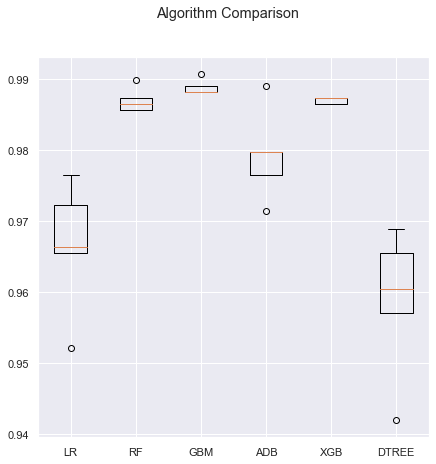

In [63]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure()

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- We can see that GBM is giving the highest cross validated recall followed by RF
- We will tune best two models i.e. RF and GBM and see if the performance improves

Hyperparameter Tuning

## Random Forest RF

### Grid Search CV

In [64]:
# Creating pipeline
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "randomforestclassifier__criterion": ['gini','entropy'],
    "randomforestclassifier__max_depth": [3, 4, 5, None],
    "randomforestclassifier__min_samples_split": [2,4,7,10,15]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__min_samples_split': 2} 
Score: 0.9944529334021246


In [65]:
# Creating new pipeline with best parameters
rf_tuned1 = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(random_state=1, criterion='entropy', max_depth=3, min_samples_split=2),
)

# Fit the model on training data
rf_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(criterion='entropy', max_depth=3,
                                        random_state=1))])

Accuracy on training set :  0.8819130925507901
Accuracy on test set :  0.8808818690358671
Recall on training set :  0.9949571356530509
Recall on test set :  0.9964719717757742
Precision on training set :  0.8800178412132025
Precision on test set :  0.8780656303972366


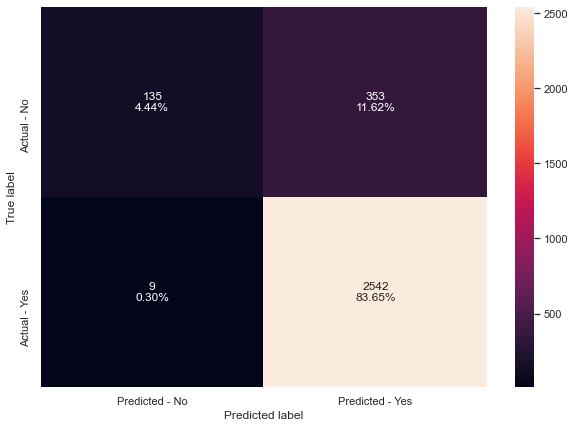

In [66]:
# Calculating different metrics
get_metrics_score(rf_tuned1)

# Creating confusion matrix
make_confusion_matrix(rf_tuned1, y_test)

- The test recall has increased by ~1% as compare to cross validated recall
- The tuned random forest model is not overfitting the test data as test and train results are similar

### Randomsearch CV

In [67]:
# Creating pipeline
pipe = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "randomforestclassifier__criterion": ['gini','entropy'],
    "randomforestclassifier__max_depth": [3, 4, 5, None],
    "randomforestclassifier__min_samples_split": [2,4,7,10,15]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=20, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__max_depth': 3, 'randomforestclassifier__criterion': 'entropy'} with CV score=0.9944529334021246:


In [68]:
# Creating new pipeline with best parameters
rf_tuned2 = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(random_state=1, criterion='entropy', max_depth=3, min_samples_split=4),
)

# Fit the model on training data
rf_tuned2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        min_samples_split=4, random_state=1))])

Accuracy on training set :  0.9149266365688488
Accuracy on test set :  0.9154327081276735
Recall on training set :  0.9613380400067238
Recall on test set :  0.9611916895335163
Precision on training set :  0.9387721602101117
Precision on test set :  0.939463601532567


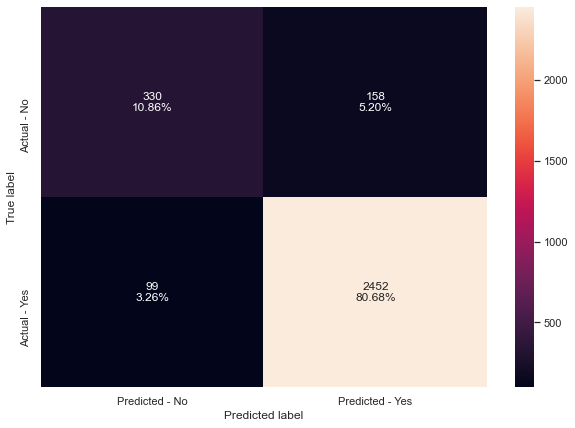

In [69]:
# Calculating different metrics
get_metrics_score(rf_tuned2)

# Creating confusion matrix
make_confusion_matrix(rf_tuned2, y_test)

In [70]:
# as compared to gridsearchCV, recall on training set has dropped by about 3% and is even lower than non-tuned recall
# however, precision performed much better than gridsearchcv set (better by 6%)

## Gradient Boosting GBM

### Grid Search CV

In [71]:
# Creating pipeline
pipe = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "gradientboostingclassifier__criterion": ['friedman_mse', 'mse'],
    "gradientboostingclassifier__max_depth": [3, 4, 5, None],
    "gradientboostingclassifier__min_samples_split": [2,7,15]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'gradientboostingclassifier__criterion': 'friedman_mse', 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__min_samples_split': 2} 
Score: 0.9880656720215419


In [72]:
# Creating new pipeline with best parameters
gbm_tuned1 = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(
     random_state=1, criterion='friedman_mse', max_depth=3, min_samples_split=2
    ),
)

# Fit the model on training data
gbm_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=1))])

Accuracy on training set :  0.9771444695259593
Accuracy on test set :  0.9631457716354064
Recall on training set :  0.9929399899142713
Recall on test set :  0.9882399059192474
Precision on training set :  0.9800895968143355
Precision on test set :  0.9684978870533999


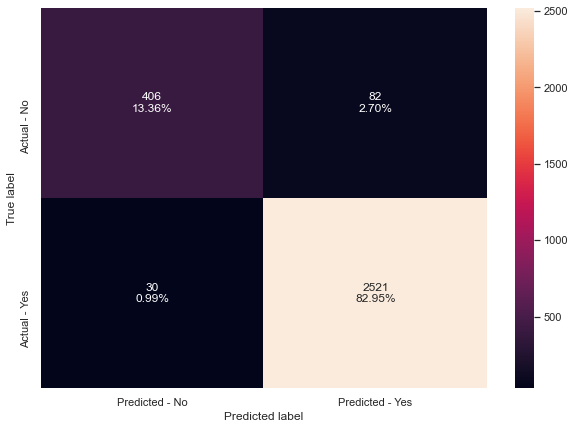

In [73]:
# Calculating different metrics
get_metrics_score(gbm_tuned1)

# Creating confusion matrix
make_confusion_matrix(gbm_tuned1, y_test)

- The test recall is similar compare to cross validated recall
- The model is not overfitting the test data as test and train results are similar

### RandomsearchCV

In [74]:
#Creating pipeline
pipe=make_pipeline(StandardScaler(),GradientBoostingClassifier(random_state=1))

#Parameter grid to pass in GridSearchCV
param_grid={"gradientboostingclassifier__criterion": ['friedman_mse', 'mse'],
    "gradientboostingclassifier__max_depth": [3, 4, 5, None],
    "gradientboostingclassifier__min_samples_split": [2,7,15]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'gradientboostingclassifier__min_samples_split': 2, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__criterion': 'friedman_mse'} with CV score=0.9880656720215419:


In [75]:
# Creating new pipeline with best parameters
gbm_tuned2 = make_pipeline(
    StandardScaler(),
    GradientBoostingClassifier(
     random_state=1, criterion='friedman_mse', max_depth=3, min_samples_split=2
    ),
)

# Fit the model on training data
gbm_tuned2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingclassifier',
                 GradientBoostingClassifier(random_state=1))])

Accuracy on training set :  0.9771444695259593
Accuracy on test set :  0.9631457716354064
Recall on training set :  0.9929399899142713
Recall on test set :  0.9882399059192474
Precision on training set :  0.9800895968143355
Precision on test set :  0.9684978870533999


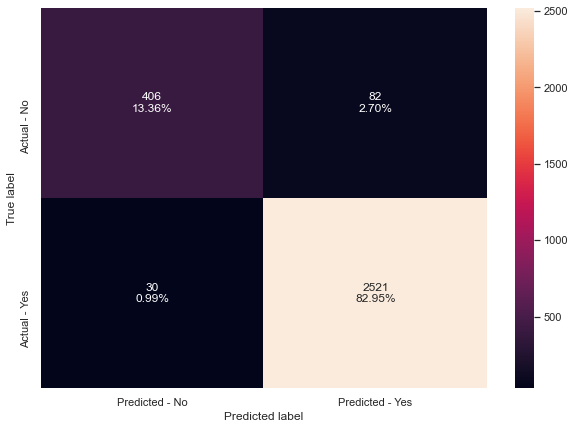

In [76]:
# Calculating different metrics
get_metrics_score(gbm_tuned2)

# Creating confusion matrix
make_confusion_matrix(gbm_tuned2, y_test)

In [77]:
# results are the same as gridsearchCV

# comparing all models

In [78]:
# defining list of models
models = [rf_tuned1, rf_tuned2, gbm_tuned1, gbm_tuned2]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:

    j = get_metrics_score(model, False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

In [79]:
comparison_frame = pd.DataFrame(
    {
        "Model": [
            "Decision Tree with GridSearchCV",
            "Decision Tree with RandomizedSearchCV",
            "XGBoost with GridSearchCV",
            "XGBoost with RandomizedSearchCV",
    
        ],
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
    }
)

# Sorting models in decreasing order of test recall
comparison_frame.sort_values(by="Test_Recall", ascending=False)

Model  Train_Accuracy  Test_Accuracy  \
0        Decision Tree with GridSearchCV        0.881913       0.880882   
2              XGBoost with GridSearchCV        0.977144       0.963146   
3        XGBoost with RandomizedSearchCV        0.977144       0.963146   
1  Decision Tree with RandomizedSearchCV        0.914927       0.915433   

   Train_Recall  Test_Recall  Train_Precision  Test_Precision  
0      0.994957     0.996472         0.880018        0.878066  
2      0.992940     0.988240         0.980090        0.968498  
3      0.992940     0.988240         0.980090        0.968498  
1      0.961338     0.961192         0.938772        0.939464

- Decision Tree with GridSearchCV has the best test recall, but compromise is made on precision
- XGBoost with GridsearchCV/RandomsearchCV produced an almost equally high recall, but with much higher precision. Hence, I will go with XGBoost

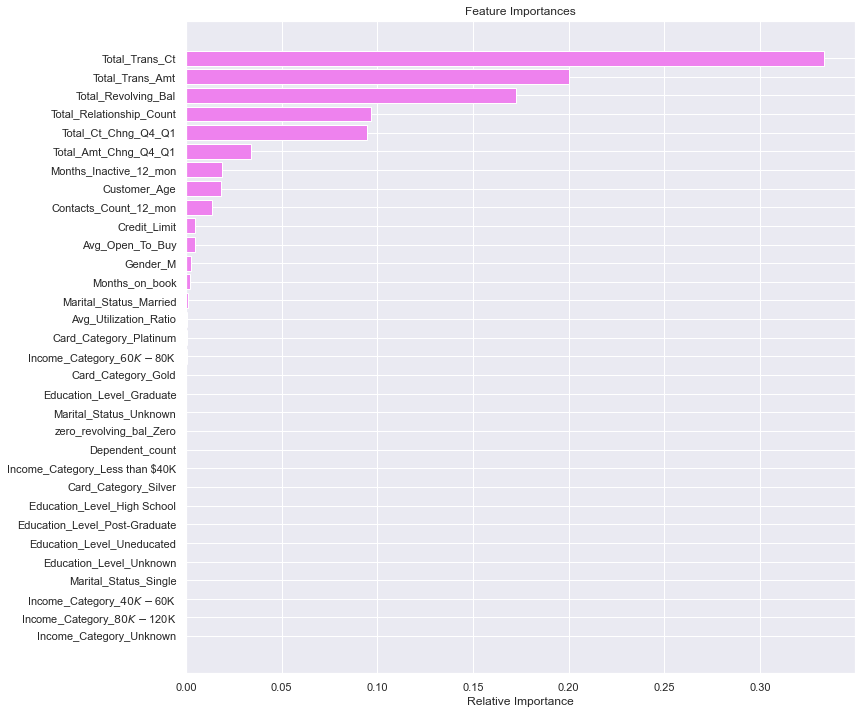

In [80]:
feature_names = X_train.columns
importances = gbm_tuned1[1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [81]:
# the most important features are transaction count and amount, and revolving balance

# Business recommendations
- the company should look at customers with low transaction counts and amounts in their credit card, as this could imply that customer is slowly losing interest in the card and will be likely to attrite soon. The company can launch a winback campaign targeting such customers
- it appears customers who have been contacted many times (contacts_count_12_mon) has a relationship with attrition. The company should look into whether the salespersons contacting the customer is well-trained to retain the customer relationship and address customer concerns
- those with fewer relationship count is more likely to attrite. The bank should look into cross-selling other products to customers holding only 1-2 products as customers with more products are seen to have more loyalty towards the bank and are less likely to attrite